# Predicting Dubai Crude Oil Prices & Returns with tsFresh: Part 1

Final Project by: Sharyl Sy & Joaquin Gonzales

In [35]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from IPython.display import Image
import lightgbm as lgb
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import itertools
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings("ignore")
from sklearn.multioutput import MultiOutputRegressor

from sklearn.linear_model import LinearRegression #add here

def mae(y_true, y_pred):
    score = np.mean(np.abs(y_true - y_pred))
    return score

def rmse(y_true, y_pred):
    score = np.sqrt(np.mean((y_true - y_pred)**2))
    return score

def mape(y_true, y_pred):
    score = np.mean(np.abs((y_true - y_pred)/y_true))
    return score

def mase(y_true, y_pred, ts):
    score = np.mean(np.abs((y_true - y_pred)/np.mean(np.abs(ts[1:] - ts[:-1]))))
    return score

def mase_sea(y_true, y_pred, ts, m):
    score = np.mean(np.abs((y_true - y_pred)/np.mean(np.abs(ts[m:] - ts[:-m]))))
    return score

def meanf(ts, h):
    f = np.mean(ts)
    f = np.repeat(f, repeats=h)
    return f

def naivef(ts, h):
    f = ts[-1]
    f = np.repeat(f, repeats=h)
    return f

def snaivef(ts, h, m):
    f = np.zeros(h)
    for i in range(h):
        f[i] = ts[-(m - i%m)]
    return f

def driftf(ts, h):
    T = len(ts)
    f = np.zeros(h)
    for i in range(h):
        f[i] = ts[-1] + (i+1)*((ts[-1] - ts[0])/(T - 1))
    return f

def plot_forecast():
    plt.figure(figsize=(15, 6))
    df_test.plot(ax=plt.gca(), label='test', legend=True)
    plt.title("Dubai Crude Oil Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    df_f.iloc[:,1:].plot(ax=plt.gca());
    plt.show()
    
def error_metrics():
    errs = {'RMSE': [], 'MAE': [], 'MAPE': []}
    for col in df_f:
        errs['RMSE'].append(rmse(df_test.to_numpy(), df_f[col].to_numpy()))
        errs['MAE'].append(mae(df_test.to_numpy(), df_f[col].to_numpy()))
        errs['MAPE'].append(mape(df_test.to_numpy(), df_f[col].to_numpy())*100)

    df_err = pd.DataFrame.from_dict(errs)
    df_err.index = df_f.columns
    display(df_err)

## 1. Prepare the dataset

We load the following datasets for the related variable of interest:
1. Dubai crude oil price - Target variable
2. US-Dollar exchange rate - Exogenous variable
3. Commodity Research Bureau index - Exogenous variable
4. Google trend on "crude oil" - Exogenous variable

In [2]:
#Crude oil price
df_crude = pd.read_csv('final-proj-data/data/dubai_crude_oil.csv', index_col=0)
df_crude.index = pd.to_datetime(df_crude.index)
df_crude = df_crude.sort_index()
df_crude.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2014-04-28,104.0,104.0,104.0,104.0,-,0.00%
2014-04-29,104.0,104.0,104.0,104.0,-,0.00%
2014-04-30,104.0,104.0,104.0,104.0,-,0.00%
2014-05-01,104.0,104.0,104.0,104.0,-,0.00%
2014-05-02,104.0,104.0,104.0,104.0,-,0.00%


In [3]:
#USD exchange rate
df_dollar = pd.read_csv('final-proj-data/data/us_dollar_index.csv', index_col=0)
df_dollar.index = pd.to_datetime(df_dollar.index)
df_dollar = df_dollar.sort_index()
df_dollar.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2014-04-28,79.762,79.805,79.910,79.615,11.60K,-0.07%
2014-04-29,79.881,79.760,79.920,79.660,10.32K,0.15%
2014-04-30,79.532,79.865,80.020,79.510,21.87K,-0.44%
2014-05-01,79.579,79.570,79.605,79.480,7.32K,0.06%
2014-05-02,79.563,79.560,79.935,79.515,23.76K,-0.02%


In [4]:
df_comm = pd.read_csv('final-proj-data/data/crb_commodity_index.csv', index_col=0)
df_comm.index = pd.to_datetime(df_comm.index)
df_comm = df_comm.sort_index()
df_comm.head()

,Open,High,Low,Close
Date,,,,
2014-04-28,311.02,311.57,309.50,309.84
2014-04-29,310.57,311.98,310.19,311.85
2014-04-30,310.35,310.67,308.96,309.53
2014-05-01,307.99,308.06,306.85,306.98
2014-05-02,307.41,307.92,306.79,307.14


In [5]:
#google trend
df_google = pd.read_csv('final-proj-data/data/crude-oil-daily-2014-2022.csv', index_col=1).iloc[:,-1]
df_google.index = pd.to_datetime(df_google.index)
df_google = df_google.sort_index()
df_google.head()

Day
2014-04-28    18
2014-04-29    15
2014-04-30    15
2014-05-01    19
2014-05-02    14
Name: crude oil: (Worldwide), dtype: int64

In [6]:
#consolidated dataframe
df_conso = pd.concat([
           df_crude.loc["2014-04-28":"2022-06-02"]['Price'], 
           df_dollar.loc["2014-04-28":"2022-06-02"]['Price'],
           df_comm.loc["2014-04-28":"2022-06-02"]['Close'],
           df_google
        ], axis=1)
df_conso.columns = ['crude', 'dollar', 'commodity_ind', 'google_trend']
df_conso

,crude,dollar,commodity_ind,google_trend
2014-04-28,104.00,79.762,309.8400,18
2014-04-29,104.00,79.881,311.8500,15
2014-04-30,104.00,79.532,309.5300,15
2014-05-01,104.00,79.579,306.9800,19
2014-05-02,104.00,79.563,307.1400,14
...,...,...,...,...
2022-05-29,NaN,NaN,NaN,9
2022-05-30,NaN,101.305,NaN,17
2022-05-31,108.13,101.766,316.5352,22
2022-06-01,110.91,102.529,320.0229,22


### 1.1 Treat missing values

We first check for presense of missing values. We drop all dates without crude prices to only consider weekdays in our forecast. We also start from July 14, 2014 since there is no variability in price prior to the date. We then apply linear imputation method to fill in other missing values.

In [7]:
df_conso.isna().sum()

crude            921
dollar           865
commodity_ind    914
google_trend       0
dtype: int64

In [8]:
df_conso = df_conso.dropna(subset=['crude']).loc["2014-07-14":]
df_conso.isna().sum()

crude            0
dollar           0
commodity_ind    1
google_trend     0
dtype: int64

In [9]:
#Impute using linear method then visualize
df_conso = df_conso.interpolate(method='linear')

### 1.2 Visualize the time series

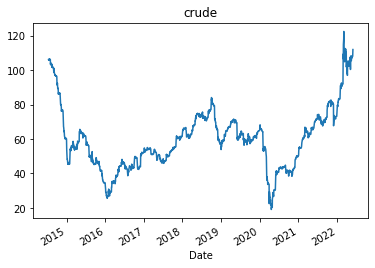

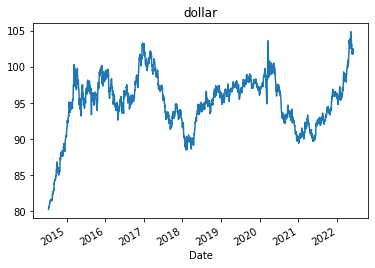

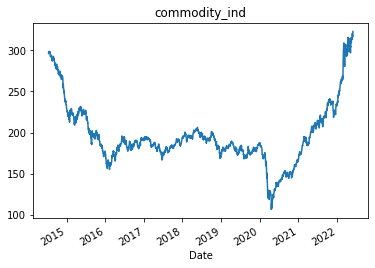

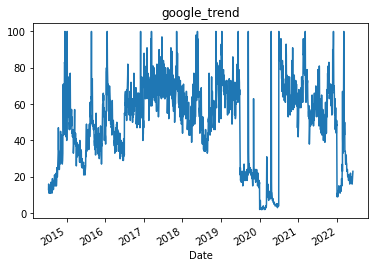

In [10]:
for axs, i in enumerate(df_conso.columns):
    df_conso.loc[:,i].plot(ax=plt.gca())
    plt.title(i)
    plt.xlabel("Date")
    plt.show()

### 1.3. Check for trends and seasonality

We check for presence of trend and seasonality. Based on ACF plot, there is a decreasing trend but there appears no seasonality. To confirm this, we check yearly plots of oil prices and see that there is indeed no yearly seasonality.

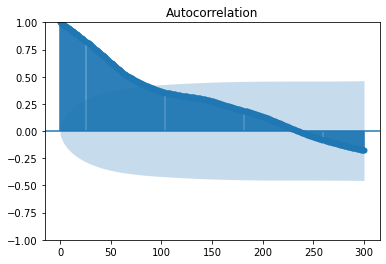

In [11]:
plot_acf(df_conso.crude, lags=300)
plt.show()

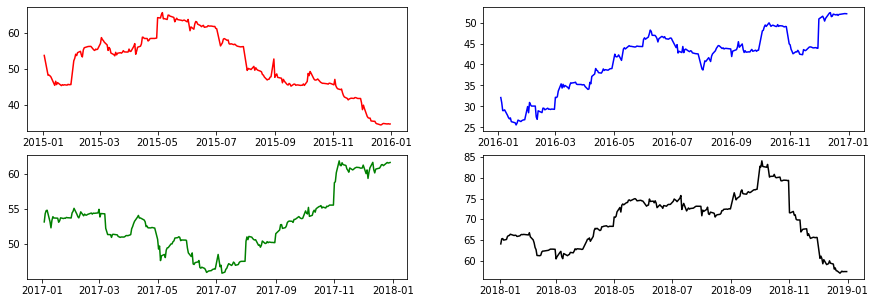

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(15,5))
ax[0, 0].plot(df_conso.crude.loc["2015-01-01":"2016-01-01"], 'r') 
ax[0, 1].plot(df_conso.crude.loc["2016-01-01":"2017-01-01"], 'b') 
ax[1, 0].plot(df_conso.crude.loc["2017-01-01":"2018-01-01"], 'g') 
ax[1, 1].plot(df_conso.crude.loc["2018-01-01":"2019-01-01"], 'k') 
plt.show()

## 2. Forecasting with Baselines

We perform the following forecasts to serve as our baseline:
1. Mean forecast
2. Naive forecast

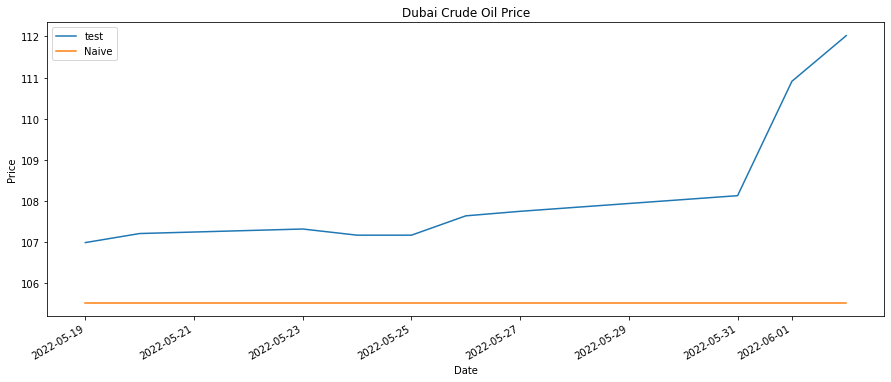

In [13]:
#Visualize
test_size = 10
df_train = df_conso.iloc[:-test_size, 0]
df_test = df_conso.iloc[-test_size:, 0]
h = test_size

df_f = pd.DataFrame()
df_f['Mean'] = meanf(df_train.to_numpy(), h=h)
df_f['Naive'] = naivef(df_train.to_numpy(), h=h)
df_f.index = df_test.index

plot_forecast()

In [14]:
#Validation metrics
error_metrics()

,RMSE,MAE,MAPE
Mean,48.548013,48.519386,44.816666
Naive,3.173993,2.701000,2.472956


## 3. Forecasting

### 3.1 Implementing Exponential Smoothing Models

We first explore forecasting using traditional univariate models such as ETS. We perform TSCV to hypertune the trend, seasonality, and damped parameter of ETS models. We divide the dataset into a train and validation set where we arrive at 11 TSCV splits.

In [15]:
#set validation set
val_size = 20
ts_train = df_train.iloc[:-val_size]
ts_val = df_train.iloc[-val_size:]

In [16]:
#ETS configurations 
trend_grid = ["add", None] #None additive damped
seasonal_grid = ["add", "mul", None] #None additive mul
damped_grid = [True, False]
ets_grid = list(itertools.product(trend_grid, seasonal_grid, damped_grid))

#allow dumped trend only if with trend
for i in ets_grid:
    if i[0] == None:
        if i[2] == True:
            ets_grid.remove(i)

df_results_ets = pd.DataFrame({'ets_param_trend_season_damp': ets_grid, 'Avg. RMSE': np.zeros(len(ets_grid))})
rmse_list = []
for conf in ets_grid:
    trend = conf[0]
    season = conf[1]
    damped = conf[2]
    for i in range(val_size - h + 1):
        last = str(ts_val.index[i:][0]).split()[0] #first validation pt
        x_train = df_train[:last][:-1]
        y_val = ts_val[i:][:h]
        #while we dont have a known seasonal period, we added yearly seasonality for cv purposes
        model = ExponentialSmoothing(x_train, trend=trend, seasonal=season, 
                                     damped_trend=damped, seasonal_periods=251).fit(optimized=True)
        y_pred = model.forecast(h)
        
        if np.isnan(y_pred.values[0]):
            continue
        else:
            rmse_list.append(rmse(y_val.to_numpy(), y_pred))
    # avg error
    df_results_ets.loc[df_results_ets['ets_param_trend_season_damp'] == conf, 'Avg. RMSE'] = np.mean(rmse_list)
    
df_results_ets

,ets_param_trend_season_damp,Avg. RMSE
0,"(add, add, True)",2.215593
1,"(add, add, False)",2.441580
2,"(add, mul, True)",2.441580
3,"(add, mul, False)",2.441580
4,"(add, None, True)",2.399185
5,"(add, None, False)",2.299065
6,"(None, add, False)",2.281782
7,"(None, mul, False)",2.281782
8,"(None, None, False)",2.280139


Based on TSCV, we select the best ETS model and evaluate it against the test set. In this case, the best ETS model is the additive damped trend and additive seasonality method.

In [17]:
best_ets_conf = df_results_ets.sort_values(by='Avg. RMSE').iloc[0]['ets_param_trend_season_damp']
trend = best_ets_conf[0]
season = best_ets_conf[1]
damped = best_ets_conf[2]
model = ExponentialSmoothing(df_train, trend=trend, seasonal=season, 
                                     damped_trend=damped, seasonal_periods=251).fit(optimized=True)
y_pred = model.forecast(h)
df_f[f'ETS @ {best_ets_conf}'] = model.forecast(h).to_numpy()

#Show validation metrics
error_metrics()

,RMSE,MAE,MAPE
Mean,48.548013,48.519386,44.816666
Naive,3.173993,2.701000,2.472956
"ETS @ ('add', 'add', True)",3.303630,2.834524,2.596515


### 3.2 Implementing a machine learning model

We apply supervised ML using LightGBM and direct forecasting to generate h predictions. We perform cross validation on the lookback period based on RMSE.

In [18]:
def train_test_split(df_data, w, h, test_size, features):

    ### Train-Test split from DataFrame ###
    
    ### Exogenous Variables ###
    feat_len = len(features)
    df_series = df_data[features]
    
    split_time = df_series.shape[0] - test_size
    
    df_train = df_series.iloc[:split_time, :]
    df_test = df_series.iloc[split_time - w:, :]

    return df_train, df_test

def create_xy(series, label, w, h, shuffle=False):
    
    ### Create (X,Y) from DataFrame ####
    
    x = []
    y = []
    for i in range(series.shape[0]):
        if series.iloc[(i + w):(i + w + h), :].shape[0] < h:
            break
        x.append(series.iloc[i:(i + w), :])
        y.append(series.iloc[(i + w):(i + w + h), :][label])
    x = np.dstack(x)
    y = np.dstack(y)
    
    # Reshape x to (samples, features, lookback)
    x = np.swapaxes(x, 0, 2)
    
    # Reshape x to (samples, horizon)
    y = np.swapaxes(y, 0, 2)
    y = y[:, :, 0]
    
    return x,y

In [19]:
w_rmse = {}
target = ['crude']
features = ['crude', 'dollar', 'commodity_ind', 'google_trend']

df_train_features = df_conso.iloc[:-test_size]

for w in list(range(44,64,2)):
    #cv
    df_train_direct, df_val_direct = train_test_split(df_train_features, w, h, test_size, features)

    train_x, train_y = create_xy(df_train_direct, target[0], w, h, shuffle=False)
    test_x, test_y = create_xy(df_val_direct, target[0], w, h, shuffle=False)

    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
    test_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2]))
    model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)
    model.fit(train_x, train_y)
    forecast_direct = model.predict(test_x).ravel()
    w_rmse[w] = rmse(df_test, forecast_direct)
df_lgbm = pd.DataFrame(w_rmse, index=['rmse']).T
df_lgbm

,rmse
44,5.805475
46,5.394159
48,5.263310
50,4.553234
52,4.030948
54,4.810821
56,4.655259
58,4.266230
60,5.106277
62,5.314719


We set the lookback period is at 52 given the lowest RMSE. We compare forecasts across all models below where LightGBM with all exploratory variables perform the best.

In [20]:
best_w = df_lgbm.sort_values('rmse').iloc[0].name
display(best_w)

df_train_direct, df_val_direct = train_test_split(df_conso, best_w, h, test_size, features)
train_x, train_y = create_xy(df_train_direct, target[0], best_w, h, shuffle=False)
test_x, test_y = create_xy(df_val_direct, target[0], best_w, h, shuffle=False)

train_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2]))
model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)
model.fit(train_x, train_y)
forecast_direct = model.predict(test_x).ravel()
df_f['LightGBM_direct'] = forecast_direct

52

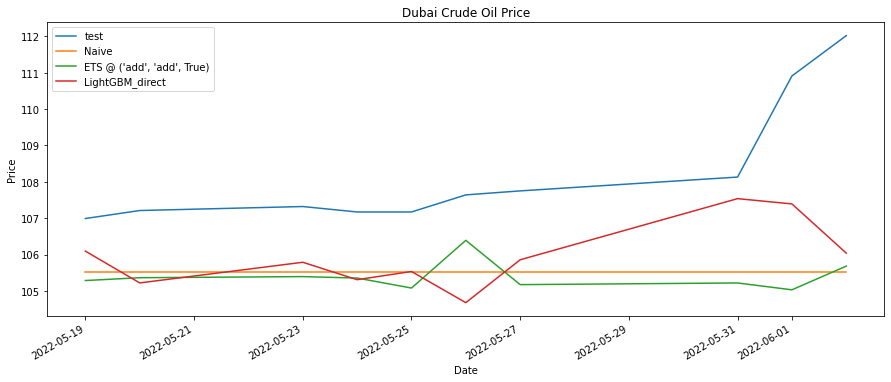

In [21]:
plot_forecast()

In [22]:
error_metrics()

,RMSE,MAE,MAPE
Mean,48.548013,48.519386,44.816666
Naive,3.173993,2.701000,2.472956
"ETS @ ('add', 'add', True)",3.303630,2.834524,2.596515
LightGBM_direct,2.722822,2.286844,2.095833


### 3.3. Implementing a machine learning regression model with tsFresh

#### 3.3.1 Multi-step forecast using LightGBM + tsFresh

In implementing tsFresh, we apply its rolling window function using `roll_time_series` to train multiple time series from a single series (similar to TSCV). At each time step, features are extracted for all time steps within the rolling window where the size of the window is manually set. A sample is shown below if rolling window is set to 10 where only observations within the rolling window are considered in the feature extraction and model training.

In [23]:
Image(url= "rolling_window.png")

First, we need to add a column to represent the entity to be predicted, in this case, crude oil. We then set the window size to 20 (similar to lookback period) and disregard all windows that are shorter than 5 days.

In [24]:
df_melted = df_conso.copy()
df_melted["date"] = df_melted.index
df_melted["item"] = "Crude Oil"
df_melted.head()

,crude,dollar,commodity_ind,google_trend,date,item
2014-07-14,106.19,80.230,297.47,13,2014-07-14,Crude Oil
2014-07-15,105.89,80.446,296.02,16,2014-07-15,Crude Oil
2014-07-16,105.94,80.625,296.79,15,2014-07-16,Crude Oil
2014-07-17,106.36,80.570,297.92,15,2014-07-17,Crude Oil
2014-07-18,105.97,80.595,297.42,11,2014-07-18,Crude Oil


In [25]:
df_rolled = roll_time_series(df_melted, column_id="item", column_sort='date',
                             max_timeshift=20, min_timeshift=5)

Rolling: 100%|██████████| 80/80 [00:03<00:00, 25.36it/s]


We then perform feature extraction using `extract_features` where features are extracted for every id generated from the rolling window step.

In [26]:
X = extract_features(df_rolled.drop("item", axis=1), 
                     column_id="id", column_sort="date", column_value="crude", 
                     impute_function=impute, show_warnings=False)
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"
X.head()

Feature Extraction: 100%|██████████| 80/80 [00:51<00:00,  1.56it/s]


,crude__variance_larger_than_standard_deviation,crude__has_duplicate_max,crude__has_duplicate_min,crude__has_duplicate,crude__sum_values,crude__abs_energy,crude__mean_abs_change,crude__mean_change,crude__mean_second_derivative_central,crude__median,...,crude__permutation_entropy__dimension_6__tau_1,crude__permutation_entropy__dimension_7__tau_1,crude__query_similarity_count__query_None__threshold_0.0,"crude__matrix_profile__feature_""min""__threshold_0.98","crude__matrix_profile__feature_""max""__threshold_0.98","crude__matrix_profile__feature_""mean""__threshold_0.98","crude__matrix_profile__feature_""median""__threshold_0.98","crude__matrix_profile__feature_""25""__threshold_0.98","crude__matrix_profile__feature_""75""__threshold_0.98",crude__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
2014-07-21,0.0,0.0,0.0,0.0,636.57,67537.0707,0.282000,0.006000,0.068750,106.080,...,-0.000000,2.708050,0.0,1.055733,3.765637,2.120209,2.03488,1.290774,2.867551,61.218571
2014-07-22,0.0,0.0,0.0,0.0,742.81,78824.0083,0.238333,0.008333,0.032000,106.190,...,0.693147,-0.000000,0.0,1.055733,3.765637,2.120209,2.03488,1.290774,2.867551,61.218571
2014-07-23,0.0,1.0,0.0,1.0,849.17,90136.4579,0.221429,0.024286,0.035000,106.205,...,1.098612,0.693147,0.0,1.055733,3.765637,2.120209,2.03488,1.290774,2.867551,106.182857
2014-07-24,0.0,1.0,0.0,1.0,955.33,101406.4035,0.218750,-0.003750,0.007143,106.190,...,1.386294,1.098612,0.0,1.055733,3.765637,2.120209,2.03488,1.290774,2.867551,106.214286
2014-07-25,0.0,0.0,0.0,1.0,1061.74,112729.4916,0.222222,0.024444,0.034375,106.205,...,1.609438,1.386294,0.0,1.055733,3.765637,2.120209,2.03488,1.290774,2.867551,106.277143


We now set y to be the forecasting target (value of next time step for h steps). We will no longer perform `select_features` function for feature selection because it requires y in scalar form as input. Since this is a multi-step forecasting procedure, our y is not in scalar form. Thus, we will train the whole model on all extracted features. We show the X_test and y_test below where columns in X_test represent all extracted aggregated features from tsFresh for the rolling window period. On the other hand, y_test represents crude oil prices for periods from 5-19-2022 to 6-2-2022, our test set.

In [27]:
y = df_melted.set_index("date").sort_index().crude
y = y.loc[:df_test.index[0]][:-1] #remove test set to avoid data leakage
final_y = []
for i in range(len(y)):
    if len(y[i+1:i+h+1]) == h:
        final_y.append(y[i+1:i+h+1].to_numpy())

df_y = pd.DataFrame(final_y, index=y.index[:-h])
df_y

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2014-07-14,105.89,105.94,106.36,105.97,106.22,106.24,106.36,106.16,106.41,106.18
2014-07-15,105.94,106.36,105.97,106.22,106.24,106.36,106.16,106.41,106.18,106.30
2014-07-16,106.36,105.97,106.22,106.24,106.36,106.16,106.41,106.18,106.30,106.20
2014-07-17,105.97,106.22,106.24,106.36,106.16,106.41,106.18,106.30,106.20,106.15
2014-07-18,106.22,106.24,106.36,106.16,106.41,106.18,106.30,106.20,106.15,103.44
...,...,...,...,...,...,...,...,...,...,...
2022-04-28,102.79,103.86,103.39,105.97,106.40,107.57,102.79,100.43,104.56,104.66
2022-04-29,103.86,103.39,105.97,106.40,107.57,102.79,100.43,104.56,104.66,107.23
2022-05-02,103.39,105.97,106.40,107.57,102.79,100.43,104.56,104.66,107.23,108.40


In [28]:
#filter to relevant common datapoints
df_y = df_y[df_y.index.isin(X.index)]
df_X = X[X.index.isin(df_y.index)]

X_test = X.loc[df_test.index[0]-timedelta(1)]

X_train = df_X[:X_test.name][:-1]
y_train = df_y[:X_test.name][:-1]

#should rename columns for lgb compatibility
X_train.columns = list(range(len(X_train.columns)))

model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)
model.fit(X_train, y_train)
forecast_tsfresh_mult_ = model.predict(pd.DataFrame(X_test).T).ravel()
df_f['tsfresh + LightGBM'] = forecast_tsfresh_mult_

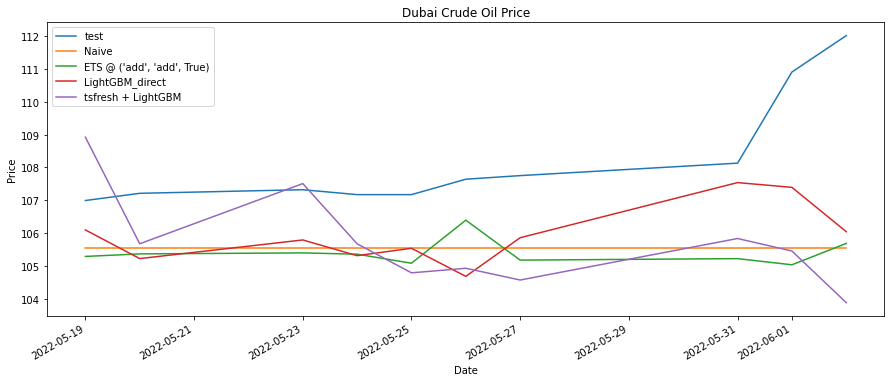

In [29]:
plot_forecast()

In [30]:
error_metrics()

,RMSE,MAE,MAPE
Mean,48.548013,48.519386,44.816666
Naive,3.173993,2.701000,2.472956
"ETS @ ('add', 'add', True)",3.303630,2.834524,2.596515
LightGBM_direct,2.722822,2.286844,2.095833
tsfresh + LightGBM,3.647465,2.934866,2.684043


#### 3.3.2 One-step forecast using Linear Regression + tsFresh

Given not so impressive results from the multi-step forecast of tsFresh, we try to implement `select_features` function of tsFresh where only relevant features are retained. In doing so, we implement a one-step forecast as it requires the y input to be in scalar form. We achieve significantly better results, albeit we are only able to forecast for the next day.

In [31]:
y = df_melted.set_index("date").sort_index().crude.shift(-1)

y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

X_train = X[:-test_size-1]
X_test = X[-test_size-1:]

y_train = y[:-test_size-1]
y_test = y[-test_size-1:][:-1].to_numpy()

In [32]:
X_train_selected = select_features(X_train, y_train)
X_test_selected = X_test[X_train_selected.columns]

model = lgb.LGBMRegressor()

#rename column names for compatibility with LightGBM
X_train_selected.columns = list(range(len(X_train_selected.columns)))
X_test_selected.columns = list(range(len(X_test_selected.columns)))

model.fit(X_train_selected, y_train)

forecast_tsfresh_one_ = pd.Series(model.predict(X_test_selected), index=X_test_selected.index)
df_f['tsfresh + LightGBM_onestep'] = forecast_tsfresh_one_

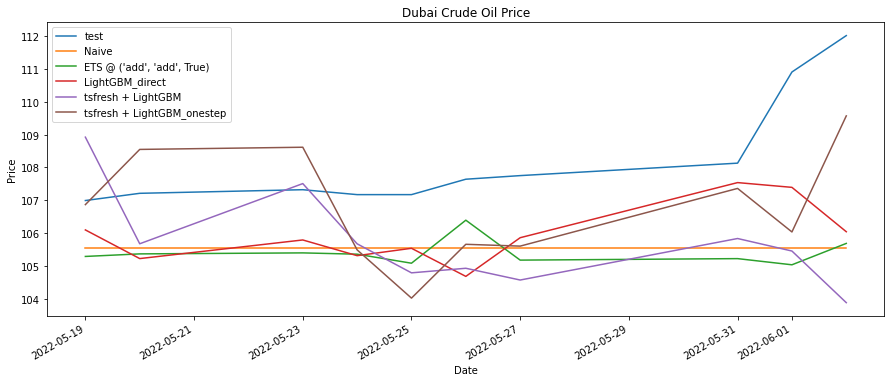

In [33]:
plot_forecast()

## Summary of Results

In [34]:
error_metrics()

,RMSE,MAE,MAPE
Mean,48.548013,48.519386,44.816666
Naive,3.173993,2.701000,2.472956
"ETS @ ('add', 'add', True)",3.303630,2.834524,2.596515
LightGBM_direct,2.722822,2.286844,2.095833
tsfresh + LightGBM,3.647465,2.934866,2.684043
tsfresh + LightGBM_onestep,2.350333,1.983314,1.822660


## References

1. All TSA notes and lectures
2. tsFresh documentation